In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

class AllButTheTop():
    def __init__(self, data_matrix):
        # Vectors in rows
        self.data_matrix = data_matrix
        self.mean_vector = np.mean(self.data_matrix, axis=0)
        self.centered_data = self.data_matrix - self.mean_vector
        self.pca = PCA()
        self.pca.fit(self.centered_data)

    def __call__(self, vector: np.array, n: int):
        centered_vector = vector - self.mean_vector
        projected_vector = self.pca.components_ @ centered_vector
        projected_vector[:n] = 0  # Zero out the top n components
        reconstructed_vector = self.pca.components_.T @ projected_vector
        
        # Unitize the vector length (unless it's zero)
        norm = np.linalg.norm(reconstructed_vector)
        return reconstructed_vector / norm if norm else reconstructed_vector


In [11]:
# Sample 100 queries, 100 chunks
queries = pd.read_json('../data/dataset/nontrivial_checked.jsonl', lines=True).sample(n=1000, random_state=42).reset_index(drop=True)
chunks = pd.read_json('../data/research_chunks.jsonl', lines=True).sample(n=1000, random_state=42).reset_index(drop=True)

In [12]:
from citeline.embedders import Embedder

embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)

query_vectors = embedder(queries['sent_no_cit'].tolist(), for_queries=True)
chunk_vectors = embedder(chunks['text'].tolist(), for_queries=False)

In [13]:
data_matrix = np.vstack([query_vectors, chunk_vectors])
print(data_matrix.shape)

(2000, 1024)


In [14]:
abtp = AllButTheTop(data_matrix)

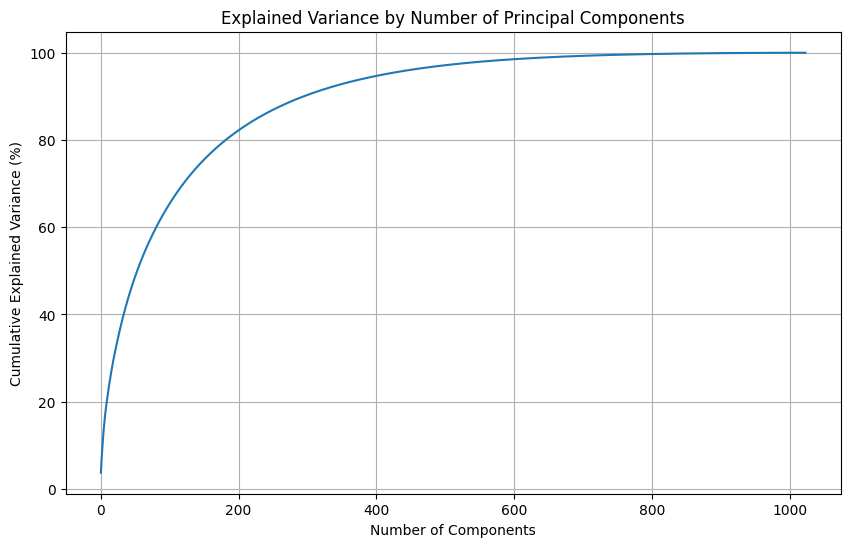

In [15]:
# Plot the explained variance ratio
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(abtp.pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()


In [16]:
vector = query_vectors[0]
transformed_vector = abtp(vector, n=10)
print("Original Vector Norm:", np.linalg.norm(vector))
print("Transformed Vector Norm:", np.linalg.norm(transformed_vector))
print("Difference Vector Norm:", np.linalg.norm(vector - transformed_vector))

Original Vector Norm: 1.0
Transformed Vector Norm: 1.0
Difference Vector Norm: 0.6744126
